In [14]:
from data.loader.custom_loader import CustomLoader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
from jiwer import cer
from jiwer import wer
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt 
import cv2
import numpy as np

In [15]:

kubhi_paths = ["../datasets/printed/Histrorical_News_Paper/combined.csv" ]
kubhist_cl = CustomLoader(kubhi_paths)
kubhist_cl.generate_dataframe()
#put ../ in every file name in the dataframe
kubhist_df = kubhist_cl.get_dataframe()
kubhist_df["file_name"] = "../" + kubhist_df["file_name"]
kubhist_df.head()

File exists: ../datasets/printed/Histrorical_News_Paper/combined.csv
Encoding: utf-8


Calculating max length: 100%|██████████| 8393/8393 [00:00<00:00, 22570.05it/s]


,file_name,text
0,../datasets/printed/Histrorical_News_Paper/TES...,denna ſekt.
1,../datasets/printed/Histrorical_News_Paper/TES...,﻿Antiomianer kallas ſå af Gre=
2,../datasets/printed/Histrorical_News_Paper/TES...,De antaga ej goda gerningar ſåſom
3,../datasets/printed/Histrorical_News_Paper/TES...,"nödwändiga medel till ſaligheten, och på="
4,../datasets/printed/Histrorical_News_Paper/TES...,"ſtå, att de utwalde ingenting kunna"


In [16]:
def preprocess_image(_image):
    """Preprocess the image using various image processing techniques."""
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(np.array(_image), cv2.COLOR_RGB2GRAY)

    # Apply binary threshold
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY_INV)

    # Define the kernel for morphological operations
    kernel = np.ones((2, 2), np.uint8)

    # Apply erosion to make lines thinner
    eroded_image = cv2.erode(binary_image, kernel, iterations=1)

    # Apply dilation to enhance the image
    dilated_image = cv2.dilate(eroded_image, kernel, iterations=1)

    # Remove noise using median filtering
    denoised_image = cv2.medianBlur(dilated_image, 3)

    # # Apply edge detection
    # edges = cv2.Canny(denoised_image, 100, 200)
    # 
    # # Fill the inside of the outlines
    # filled_image = cv2.bitwise_not(edges)
    # h, w = filled_image.shape[:2]
    # mask = np.zeros((h+2, w+2), np.uint8)
    # cv2.floodFill(filled_image, mask, (0, 0), 255)
    # filled_image = cv2.bitwise_not(filled_image)
    # final_image = cv2.bitwise_or(edges, filled_image)
    # 
    # Deskew the image (assuming the text is mostly horizontal)
    coords = np.column_stack(np.where(denoised_image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = denoised_image.shape[:2]
    center = (w // 2, h // 2)
    m = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed_image = cv2.warpAffine(denoised_image, m, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Convert back to 3 dimensions if necessary
    if len(deskewed_image.shape) == 2:
        deskewed_image = cv2.cvtColor(deskewed_image, cv2.COLOR_GRAY2RGB)

    return Image.fromarray(deskewed_image)

In [17]:

def pad_text(text, length, pad_char='*'):
    """Pad the text with the specified character to match the given length."""
    return text + pad_char * (length - len(text))

def evaluate_wer_and_cer_and_mismatched_chars(_model, _processor, _dataset):
    if torch.cuda.is_available():
        _model = _model.to('cuda')  # Move model to GPU
    _model = _model.eval()
    wer_scores = []
    cer_scores = []
    mismatched_chars = defaultdict(int)
    char_errors_per_image = []
    cer_scores_per_image = []  # List to store CER scores for each image

    for _, example in tqdm(_dataset.iterrows(), total=len(_dataset)):
        image_path = example["file_name"]
        _ground_truth_text = example["text"]

        # Load the image
        _image = Image.open(image_path).convert("RGB")

        # Make lines thinner
        _image = preprocess_image(_image)

        # Preprocess the image
        pixel_values = _processor(images=_image, return_tensors="pt").pixel_values
        if torch.cuda.is_available():
            pixel_values = pixel_values.to('cuda')  # Move input tensor to GPU

        # Generate prediction
        with torch.no_grad():
            generated_ids = _model.generate(pixel_values)
        _predicted_text = _processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        # Pad the predicted text to match the length of the ground truth text
        padded_predicted_text = pad_text(_predicted_text, len(_ground_truth_text))

        # Calculate WER and CER
        wer_score = wer(_ground_truth_text, padded_predicted_text)
        cer_score = cer(_ground_truth_text, padded_predicted_text)
        wer_scores.append(wer_score)
        cer_scores.append(cer_score)
        cer_scores_per_image.append(cer_score)  # Append CER score for this image

        # Calculate character errors for this image
        char_errors = sum(1 for gt_char, pred_char in zip(_ground_truth_text, padded_predicted_text) if gt_char != pred_char)
        char_errors_per_image.append((len(_ground_truth_text), char_errors))

        # Compare ground truth and predicted text character by character
        for gt_char, pred_char in zip(_ground_truth_text, padded_predicted_text):
            if gt_char != pred_char:
                mismatched_chars[(gt_char, pred_char)] += 1

    # Return the average WER, average CER, mismatched characters frequency, character errors per image, and CER scores per image
    _average_wer = sum(wer_scores) / len(wer_scores)
    _average_cer = sum(cer_scores) / len(cer_scores)
    return _average_wer, _average_cer, dict(mismatched_chars), char_errors_per_image, cer_scores_per_image

In [30]:
def draw_scatter_plot_with_cer_scores(char_errors_per_image, cer_scores_per_image):
    # Filter points with CER score below and above 1
    below_one_cer = [(gt_len, char_err, _cer) for (gt_len, char_err), _cer in zip(char_errors_per_image, cer_scores_per_image) if _cer < 1]
    above_one_cer = [(gt_len, char_err, _cer) for (gt_len, char_err), _cer in zip(char_errors_per_image, cer_scores_per_image) if _cer >= 1]

    # Find the index of the image with the lowest CER score
    min_cer_score = min(cer_scores_per_image)
    min_cer_index = cer_scores_per_image.index(min_cer_score)
    min_cer_gt_len = char_errors_per_image[min_cer_index][0]
    min_cer_char_err = char_errors_per_image[min_cer_index][1]

    # Create a scatter plot
    plt.figure(figsize=(10, 6))

    # Plot points with CER score below 1
    below_one_gt_lens = [x[0] for x in below_one_cer]
    below_one_cer = [x[2] for x in below_one_cer]
    plt.scatter(below_one_gt_lens, below_one_cer, edgecolor='w', linewidth=0.2, color='green', alpha=0.6, label=f'Below CER 1: ({len(below_one_cer)})')

    # Plot points with CER score above or equal to 1
    above_one_gt_lens = [x[0] for x in above_one_cer]
    above_one_cer = [x[2] for x in above_one_cer]
    plt.scatter(above_one_gt_lens, above_one_cer, alpha=0.6, edgecolor='w', linewidth=0.5, label=f'Above or equal CER 1: {len(above_one_cer)}')

    # Draw a horizontal line at CER score 1
    plt.axhline(y=1, color='red', linestyle='--', linewidth=1, label='Baseline CER = 1')

    # Set labels, title, and enhance plot aesthetics
    plt.xlabel("Ground Truth Text Length")
    plt.ylabel("CER Score")
    plt.title("Ground Truth Text Length vs CER Score")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.3, linewidth=0.5)
    plt.minorticks_on()
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.5))
    plt.show()

In [48]:
import pandas as pd

def draw_box_plot_with_cer_scores(char_errors_per_image, cer_scores_per_image):
    # Extract ground truth text lengths and CER scores
    gt_lengths = [x[0] for x in char_errors_per_image]
    cer_scores = cer_scores_per_image

    # Create a DataFrame for easier manipulation
    data = pd.DataFrame({'gt_length': gt_lengths, 'cer_score': cer_scores})

    # Define bins for ground truth text lengths
    bins = np.arange(0, max(gt_lengths) + 10, 10)
    data['gt_length_bin'] = pd.cut(data['gt_length'], bins)

    # Plot the box plot
    plt.figure(figsize=(12, 6))
    data.boxplot(column='cer_score', by='gt_length_bin', grid=False, showfliers=False)
    plt.xticks(rotation=45)
    plt.xlabel('Ground Truth Text Length (binned)')
    plt.ylabel('CER Score')
    plt.title('Box Plot of CER Scores by Ground Truth Text Length')
    plt.suptitle('')  # Suppress the default title
    plt.show()

In [19]:
def show_image_with_lowest_cer(cer_scores_per_image, dataset, model, processor):
    # Find the image with the lowest CER score
    min_cer_score = min(cer_scores_per_image)
    min_cer_index = cer_scores_per_image.index(min_cer_score)

    # Get the corresponding file path and ground truth text from the dataset
    image_info = dataset.iloc[min_cer_index]
    image_path = image_info["file_name"]
    ground_truth_text = image_info["text"]

    # Load the image
    image = Image.open(image_path).convert("RGB")
    
    # Preprocess the image
    image = preprocess_image(image)

    # Preprocess the image
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    if torch.cuda.is_available():
        pixel_values = pixel_values.to('cuda')  # Move input tensor to GPU

    # Generate prediction
    model = model.eval()
    with torch.no_grad():
        generated_ids = model.generate(pixel_values, num_beams=6)
    predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # Pad the predicted text to match the length of the ground truth text
    padded_predicted_text = pad_text(predicted_text, len(ground_truth_text))
    
    # Display the image with predicted and ground truth text
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Ground Truth: {ground_truth_text}\nPredicted: {padded_predicted_text}\nCER: {min_cer_score:.2f}")
    plt.show()

In [20]:
# Evaluate the model and get mismatched characters frequency
# Load the pre-trained TrOCR model and processor
htr_vision_model = VisionEncoderDecoderModel.from_pretrained("../custom_models/trocr-handwritten/w_augmentation/small/1.3/vision_model")
htr_processor = TrOCRProcessor.from_pretrained("../custom_models/trocr-handwritten/w_augmentation/small/1.3/processor")

htr_model_avg_wer, htr_model_l_avg_cer, htr_model_l_avg_cerl_mismatched_chars_freq, htr_model_char_errors_per_image, htr_model_cer_scores_per_image = evaluate_wer_and_cer_and_mismatched_chars(htr_vision_model, htr_processor, kubhist_df[:4000])
print(f"HTR model not trained with printed text Average CER: {htr_model_l_avg_cer}")
print(f"HTR model not trained with printed text Average WER: {htr_model_avg_wer}")
#

100%|██████████| 4000/4000 [15:36<00:00,  4.27it/s]

HTR model not trained with printed text Average CER: 0.9762589588017616
HTR model not trained with printed text Average WER: 1.0952638159688184


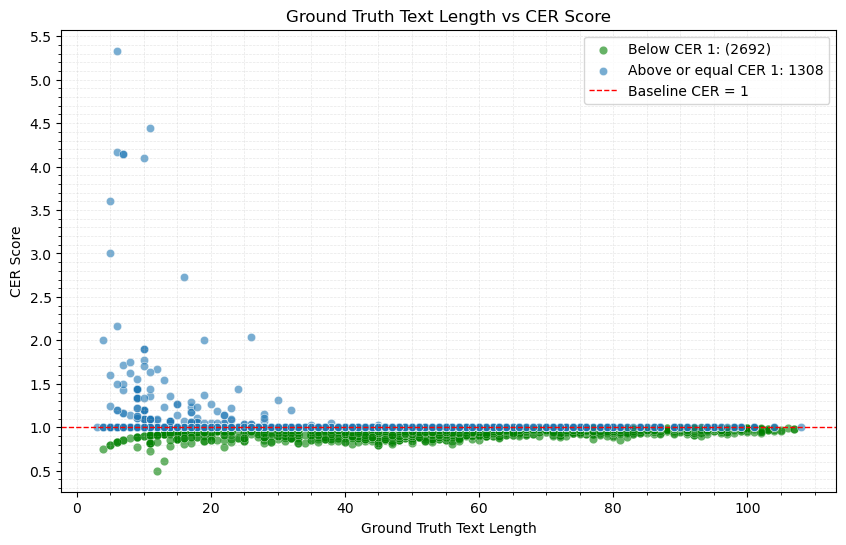

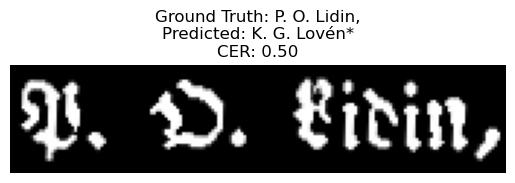

<Figure size 1200x600 with 0 Axes>

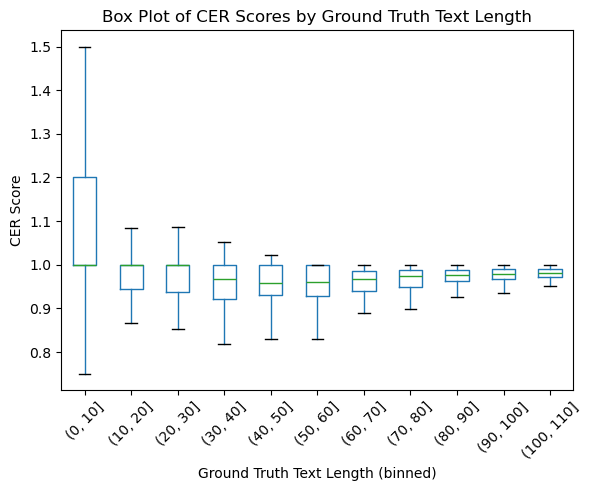

In [49]:
# show the  |
draw_scatter_plot_with_cer_scores(htr_model_char_errors_per_image, htr_model_cer_scores_per_image)
show_image_with_lowest_cer(htr_model_cer_scores_per_image, kubhist_df, htr_vision_model, htr_processor)
draw_box_plot_with_cer_scores(htr_model_char_errors_per_image, htr_model_cer_scores_per_image)

In [22]:
# Evaluate the model and get mismatched characters frequency
# Load the pre-trained TrOCR model and processor
small_medium_model = VisionEncoderDecoderModel.from_pretrained("../custom_models/trocr-printed/w_augmentation/small_medium/1.0/vision_model")
small_medium_processor = TrOCRProcessor.from_pretrained("../custom_models/trocr-printed/w_augmentation/small_medium/1.0/processor")

small_medium_model_avg_wer, small_medium_model_avg_cer, small_medium_model_mismatched_chars_freq, small_medium_model_char_errors_per_image, small_medium_model_cer_scores_per_image = evaluate_wer_and_cer_and_mismatched_chars(small_medium_model, small_medium_processor, kubhist_df[:4000])
print(f"Small medium model trained on 250k synthetic dataset Average CER: {small_medium_model_avg_cer}")
print(f"Small medium model trained on 250k synthetic dataset Average WER: {small_medium_model_avg_wer}")

100%|██████████| 4000/4000 [19:29<00:00,  3.42it/s]

Small medium model trained on 250k synthetic dataset Average CER: 0.9776333635859905
Small medium model trained on 250k synthetic dataset Average WER: 1.2573041575351476


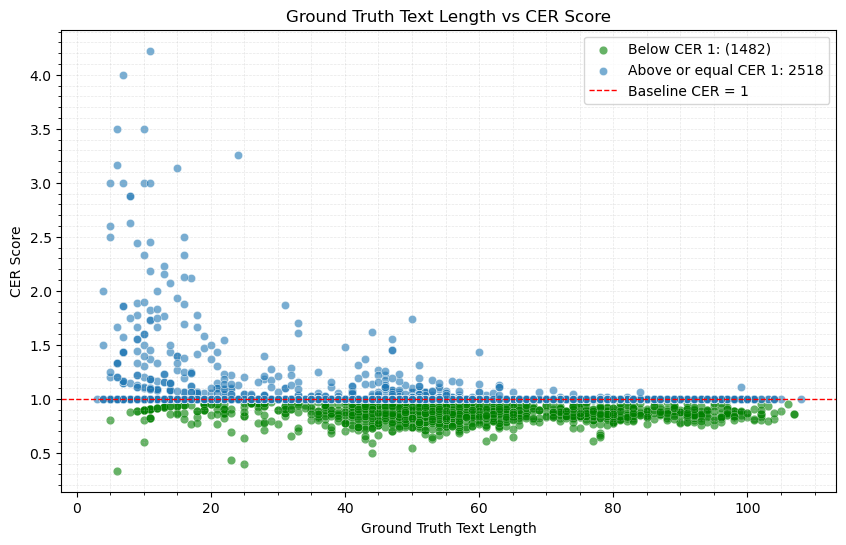

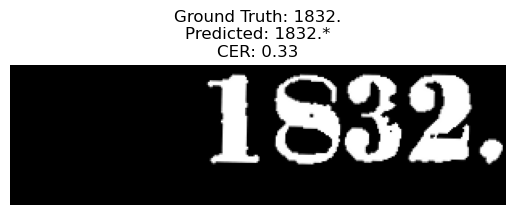

<Figure size 1200x600 with 0 Axes>

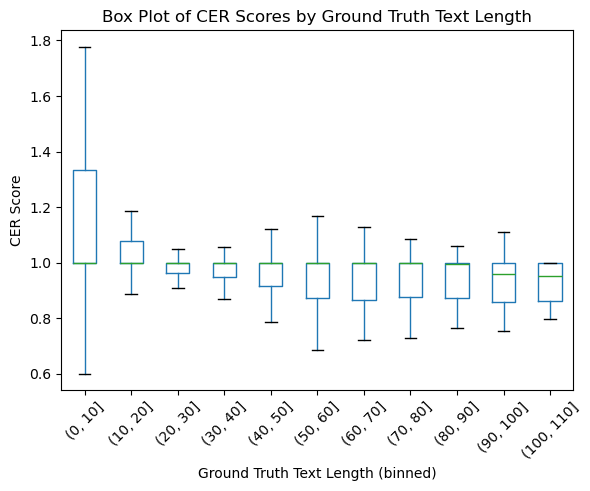

In [50]:
# show the  
draw_scatter_plot_with_cer_scores(small_medium_model_char_errors_per_image, small_medium_model_cer_scores_per_image)
show_image_with_lowest_cer(small_medium_model_cer_scores_per_image, kubhist_df, small_medium_model, htr_processor)
draw_box_plot_with_cer_scores(small_medium_model_char_errors_per_image, small_medium_model_cer_scores_per_image)

In [24]:
# Load the pre-trained TrOCR model and processor
small_model = VisionEncoderDecoderModel.from_pretrained("../custom_models/trocr-printed/w_augmentation/small/1.1/vision_model")
small_processor = TrOCRProcessor.from_pretrained("../custom_models/trocr-printed/w_augmentation/small/1.1/processor")

small_model_avg_wer, small_model_avg_cer, small_model_mismatched_chars_freq, small_model_char_errors_per_image, small_model_cer_scores_per_image = evaluate_wer_and_cer_and_mismatched_chars(small_model, small_processor, kubhist_df[:4000])
print(f"Small model trained on 120k synthetic dataset average CER: {small_model_avg_cer}")
print(f"Small model trained on 120k synthetic dataset average WER: {small_model_avg_wer}")

100%|██████████| 4000/4000 [26:04<00:00,  2.56it/s]

Small model trained on 120k synthetic dataset average CER: 0.9911928597274875
Small model trained on 120k synthetic dataset average WER: 1.4206217174369777


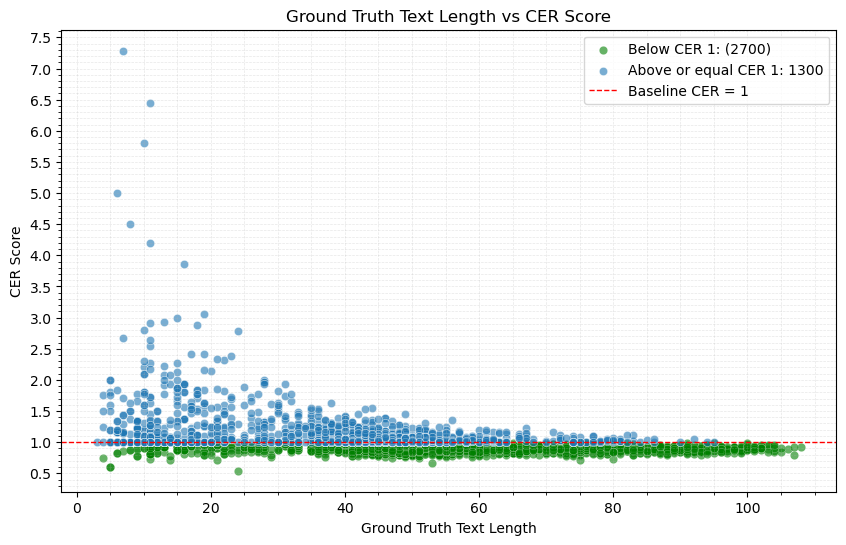

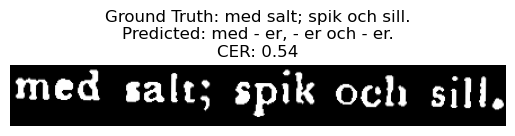

<Figure size 1200x600 with 0 Axes>

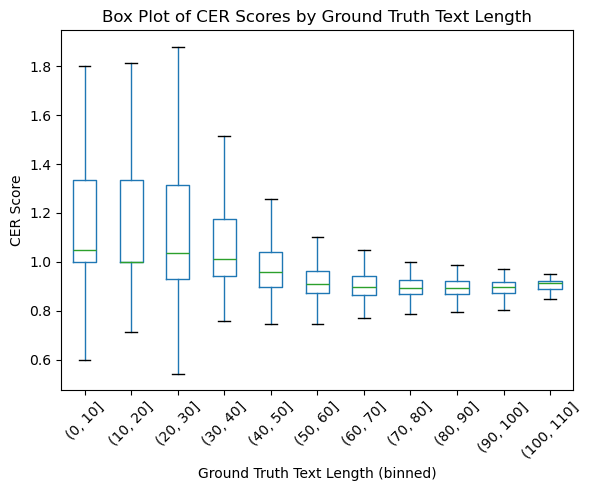

In [51]:
# show the  
draw_scatter_plot_with_cer_scores(small_model_char_errors_per_image, small_model_cer_scores_per_image)
show_image_with_lowest_cer(small_model_cer_scores_per_image, kubhist_df, small_model, htr_processor)
draw_box_plot_with_cer_scores(small_model_char_errors_per_image, small_model_cer_scores_per_image)

In [26]:
# transfer learning
# Load the pre-trained TrOCR model and processor
tl_small_model = VisionEncoderDecoderModel.from_pretrained("../custom_models/trocr-printed/transfer-learning/small/1.1/vision_model")
tl_small_processor = TrOCRProcessor.from_pretrained("../custom_models/trocr-printed/transfer-learning/small/1.1/processor")

tl_small_model_avg_wer, tl_small_model_avg_cer, tl_small_model_mismatched_chars_freq, tl_small_model_char_errors_per_image, tl_small_model_cer_scores_per_image = evaluate_wer_and_cer_and_mismatched_chars(tl_small_model, tl_small_processor, kubhist_df[:4000])
print(f"transfer learned HTR with small synthetic dataset 120k model average CER: {tl_small_model_avg_cer}")
print(f"transfer learned HTR with small synthetic dataset 120k model average WER: {tl_small_model_avg_wer}")

100%|██████████| 4000/4000 [20:25<00:00,  3.26it/s] 

transfer learned HTR with small synthetic dataset 120k model average CER: 0.940426980005202
transfer learned HTR with small synthetic dataset 120k model average WER: 1.1693001709451116


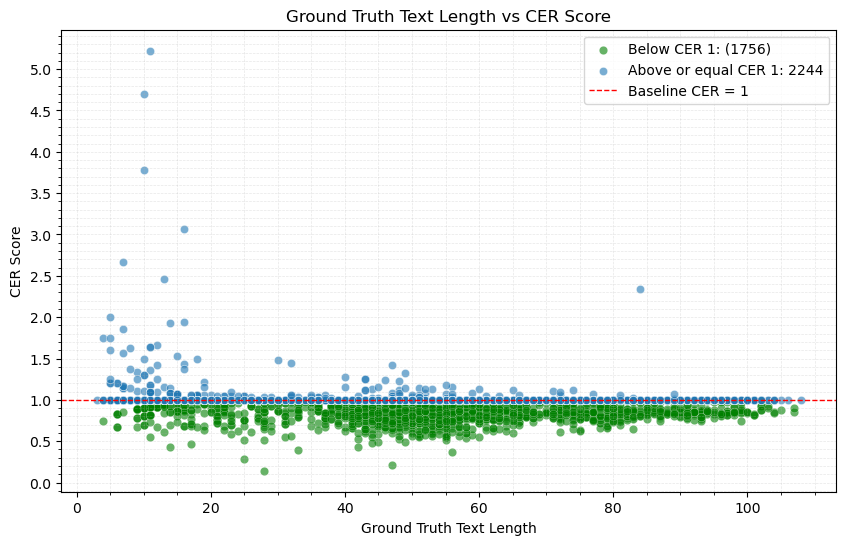

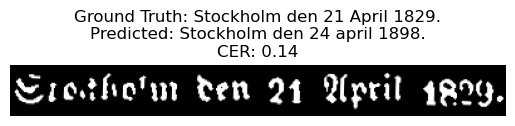

<Figure size 1200x600 with 0 Axes>

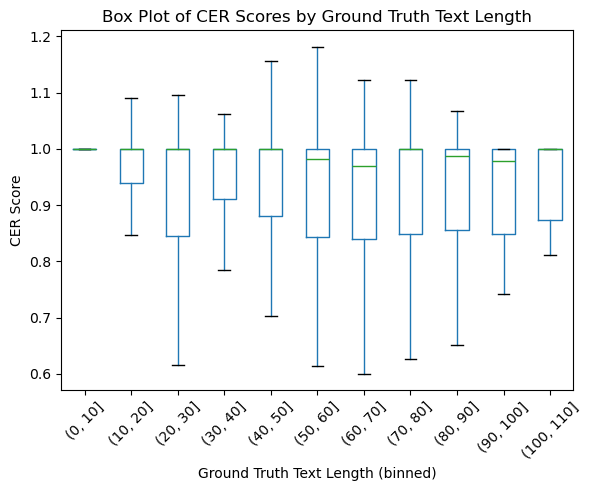

In [52]:
# show the  
draw_scatter_plot_with_cer_scores(tl_small_model_char_errors_per_image, tl_small_model_cer_scores_per_image)
show_image_with_lowest_cer(tl_small_model_cer_scores_per_image, kubhist_df, tl_small_model, htr_processor)
draw_box_plot_with_cer_scores(tl_small_model_char_errors_per_image, tl_small_model_cer_scores_per_image)

In [28]:
# transfer learning
# Load the pre-trained TrOCR model and processor
tl_tiny_model = VisionEncoderDecoderModel.from_pretrained("../custom_models/trocr-printed/transfer-learning/tiny/1.0/vision_model")
tl_tiny_processor = TrOCRProcessor.from_pretrained("../custom_models/trocr-printed/transfer-learning/tiny/1.0/processor")

tl_tiny_model_avg_wer, tl_tiny_model_avg_cer, tl_tiny_model_mismatched_chars_freq, tl_tiny_model_char_errors_per_image, tl_tiny_model_cer_scores_per_image = evaluate_wer_and_cer_and_mismatched_chars(tl_tiny_model, tl_tiny_processor, kubhist_df[:4000])
print(f"transfer learned HTR with tiny synthetic dataset 42k model average CER: {tl_tiny_model_avg_cer}")
print(f"transfer learned HTR with tiny synthetic dataset 42k model average WER: {tl_tiny_model_avg_wer}")

100%|██████████| 4000/4000 [22:57<00:00,  2.90it/s]

transfer learned HTR with tiny synthetic dataset 42k model average CER: 0.987775303245648
transfer learned HTR with tiny synthetic dataset 42k model average WER: 1.3063514694198126


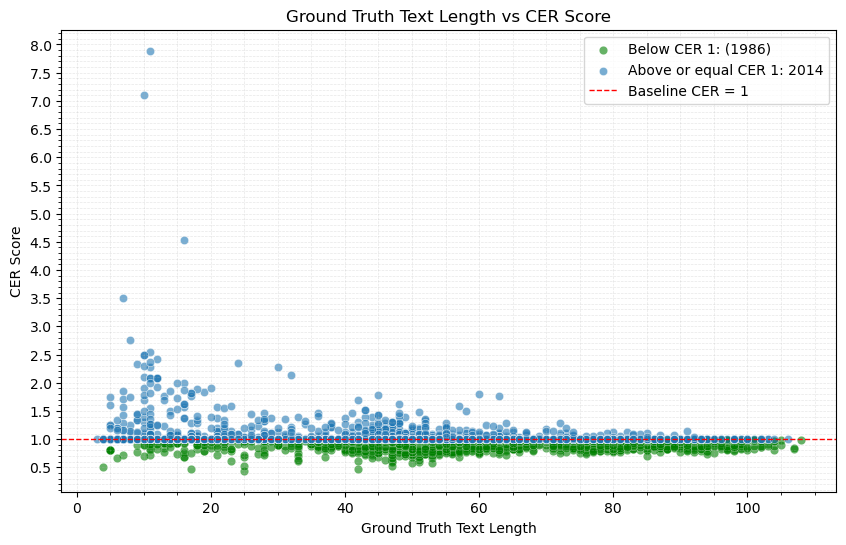

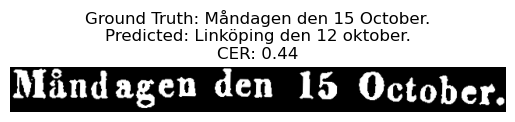

<Figure size 1200x600 with 0 Axes>

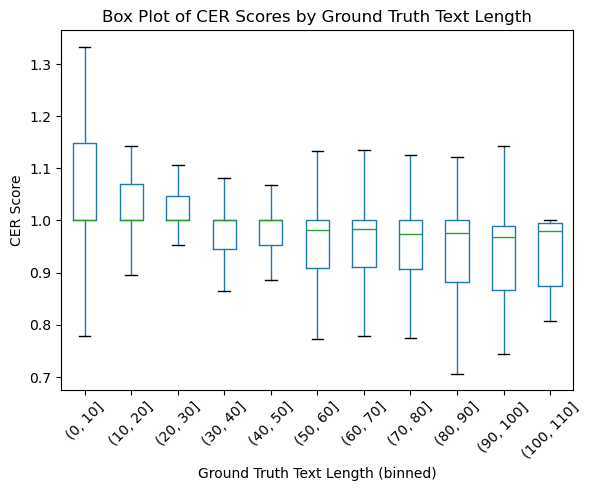

In [44]:
# show the  
draw_scatter_plot_with_cer_scores(tl_tiny_model_char_errors_per_image, tl_tiny_model_cer_scores_per_image)
show_image_with_lowest_cer(tl_tiny_model_cer_scores_per_image, kubhist_df, tl_tiny_model, htr_processor)
draw_box_plot_with_cer_scores(tl_tiny_model_char_errors_per_image, tl_tiny_model_cer_scores_per_image)